In [ ]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import random

random.seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/CMPE-252

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/CMPE-252


In [ ]:
CONST_GAMMA = 0.9
CONST_ACTION_LST = ('U','D','L','R')
CONST_N_EPISODES = 20000
CONST_EPSILON = 0.9

In [ ]:
# original_maze = np.array([
#   [ 1., 1., 1., 1., 1., 1., 1., 1000.],
#   [ 0., 0., 0., 0., 0., 0., 1., -1000.],
#   [ 1., 1., 1., 1., 1., 1., 1., 1.],
#   [ 1., 1., 1., 1., 1., 1., 1., 1.],
#   [ 1., 0., 0., 0., 0., 0., 0., 1.],
#   [ 1., 0., 1., 1., 1., 1., 1., 1.],
#   [ 1., 0., 1., 0., 0., 0., 0., 1.],
#   [ 1., 1., 1., 1., 1., 1., 1., 1.],
# ])

In [ ]:
## LAYOUT OF THE GRID

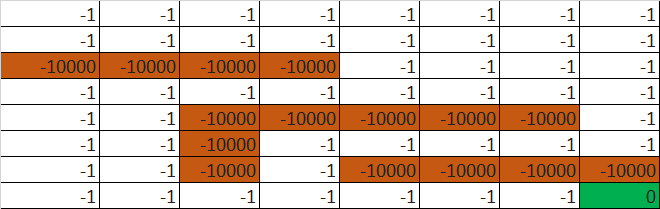

In [ ]:
path = -1.
wall = -10000.
pend = 0.
# nend = -1000.
start = (0,0)
goal = (7,7)

# original_maze = np.array([
#   [ path, path, path, path, pend],
#   [ path, path, path, path, path],
#   [ wall, wall, wall, path, path],
#   [ path, path, path, path, path],
#   [ path, path, path, path, path],
# ])


In [ ]:
original_maze = np.array([
  [ path, path, path, path, path, path, path, path],
  [ path, path, path, path, path, path, path, path],
  [ wall, wall, wall, wall, wall, path, path, path],
  [ path, path, path, path, path, path, path, path],
  [ path, path, wall, wall, wall, wall, wall, path],
  [ path, path, wall, path, path, path, path, path],
  [ path, path, wall, path, wall, wall, wall, wall],
  [ path, path, path, path, path, path, path, pend],
])

In [ ]:
nrows, ncols = original_maze.shape

free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if original_maze[(r,c)] == path]
blocked_cells = [(r,c) for r in range(nrows) for c in range(ncols) if original_maze[(r,c)] == wall]

terminal_states = [(r,c) for r in range(nrows) for c in range(ncols) if original_maze[(r,c)] != path and original_maze[(r,c)] != wall]

# actions  = {curr_cell : (possible actions)}
actions = defaultdict(list)

for i,j in free_cells:
    if j-1 >= 0 and (i,j-1) not in blocked_cells:    actions[(i,j)].append('L')
    if j+1 < ncols and (i,j+1) not in blocked_cells:  actions[(i,j)].append('R')
    if i-1 >= 0 and (i-1,j) not in blocked_cells: actions[(i,j)].append('U')
    if i+1 < nrows and (i+1,j) not in blocked_cells:    actions[(i,j)].append('D')

rewards = {cells: path for cells in free_cells}
rewards.update({cells: wall for cells in blocked_cells})
rewards.update({goal: pend})
print(terminal_states)


[(7, 7)]


In [ ]:
print("free_cells \t", free_cells)
print("blocked cells \t", blocked_cells)

free_cells 	 [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 7), (5, 0), (5, 1), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 3), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
blocked cells 	 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 2), (6, 2), (6, 4), (6, 5), (6, 6), (6, 7)]


In [ ]:
 class Grid: # Environment
  def __init__(self, width, height, start):
    # i is vertical axis, j is horizontal
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions, terminal_states, obey_prob):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions
    self.obey_prob = obey_prob
    self.terminal_states = terminal_states

  def non_terminal_states(self):
    return self.actions.keys()

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s in self.terminal_states

  def stochastic_move(self, action):
    p = np.random.random()
    if p <= self.obey_prob:
      return action
    if action == 'U' or action == 'D':
      return np.random.choice(['L', 'R'])
    elif action == 'L' or action == 'R':
      return np.random.choice(['U', 'D'])

  def move(self, action):
    actual_action = self.stochastic_move(action)
    if actual_action in self.actions[(self.i, self.j)]:
      if actual_action == 'U':
        self.i -= 1
      elif actual_action == 'D':
        self.i += 1
      elif actual_action == 'R':
        self.j += 1
      elif actual_action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def check_move(self, action):
    i = self.i
    j = self.j
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        i -= 1
      elif action == 'D':
        i += 1
      elif action == 'R':
        j += 1
      elif action == 'L':
        j -= 1
    # return a reward (if any)
    reward = self.rewards.get((i, j), 0)
    return ((i, j), reward)

  def get_transition_probs(self, action):
    # returns a list of (probability, reward, s') transition tuples
    probs = []
    state, reward = self.check_move(action)
    probs.append((self.obey_prob, reward, state))
    disobey_prob = 1 - self.obey_prob
    if not (disobey_prob > 0.0):
      return probs
    if action == 'U' or action == 'D':
      state, reward = self.check_move('L')
      probs.append((disobey_prob / 2, reward, state))
      state, reward = self.check_move('R')
      probs.append((disobey_prob / 2, reward, state))
    elif action == 'L' or action == 'R':
      state, reward = self.check_move('U')
      probs.append((disobey_prob / 2, reward, state))
      state, reward = self.check_move('D')
      probs.append((disobey_prob / 2, reward, state))
    return probs

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) in terminal_states

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


In [ ]:
def standard_grid(obey_prob=1, step_cost=None):
  g = Grid(nrows, ncols, start)  

  g.set(rewards, actions, terminal_states, obey_prob)
  if step_cost is not None:
      for r,c in free_cells: g.rewards[(r,c)] = step_cost

  return g

In [ ]:
def print_values(V, g):
  for i in range(g.width):
    print("----------------------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="")
    print("")

def print_policy(P, g):
  for i in range(g.width):
    print("----------------------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")  
    print("")

def max_dict(d):
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [ ]:
def epsilon_action(a,eps = 0.1):
    """ 
    epsilon greedy. Chooses either action a or an radom action with epsioln probablility
    Args: None
    Return: None
    """
    rand_number = np.random.random()
    if rand_number < (1-eps):
        return a
    else:
        return np.random.choice(CONST_ACTION_LST)

def play_a_game(grid,policy):
    """ 
    Function for playing a gridworld game
    Args: grid: the grid world object, policy: the current policy matrix 
    Return: statematrix, actions and gain (s,a,g)
    Examples: 
        states_actions_returns = play_game(grid, policy) 
        for s, a, G in states_actions_returns:
    """
    #set to the start state.
    s = start
    grid.set_state(s)
    a = epsilon_action(policy[s], CONST_EPSILON) #choose an action epsilon greedy

    #play till game over. g is always one step behind
    states_actions_rewards = [(s, a, 0)]
    
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = epsilon_action(policy[s], CONST_EPSILON)
            states_actions_rewards.append((s, a, r)) 
        # print(states_actions_rewards)   

    #caluculate the gains by working backwards form the terminal state
    G = 0
    state_action_gain = []
    first = True
    for s,a,r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            state_action_gain.append((s,a,G))
        G = r + CONST_GAMMA*G
    state_action_gain.reverse() #the loop above reverses the order
    return state_action_gain


def monte_carlo(grid):
    """ 
    Functions runs games and updates the value function monte carlo style
    Args: grid: The grid world
    Return: Value gunction, Policy fuction, Delta list
    """
    #Create a random policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(CONST_ACTION_LST)
    
    #Init Q(s,a) function and return
    Q = {}
    returns =  {}
    for s in grid.non_terminal_states():
        Q[s] = {}
        for a in CONST_ACTION_LST:
            Q[s][a] = 0
            returns[(s,a)] = []
    
    # protocol changes of the Q values in each episode
    deltas = []
    accumulated_rewards = []
    # run the monte carlo approimation for a specified amount of times
    for t in tqdm(range(CONST_N_EPISODES)):
        rewards = 0
        biggest_change = 0
        states_actions_returns = play_a_game(grid, policy)

        # calculate Q(s,a)
        seen_state_action_pairs = set()
        for s, a, G in states_actions_returns:
        # check if we have already seen, otherwise skip (first-visit insead of every visit)
            sa = (s, a)
            rewards += G
            if sa not in seen_state_action_pairs:
                returns[sa].append(G)
                old_q = Q[s][a]
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_state_action_pairs.add(sa)
            deltas.append(biggest_change)
        accumulated_rewards.append(rewards)
        # calculate new policy p[s] = argmax[a]{Q(s,a)}
        for s in policy.keys():
            a, _ = max_dict(Q[s])
            policy[s] = a
    
    # calculate values for each state (just to print and compare)
    # V(s) = max[a]{ Q(s,a) }
    V = {}
    for s in policy.keys():
        V[s] = max_dict(Q[s])[1] #this function was givin by utils and is basically argmax for a python dict
    
    return V, policy, deltas, accumulated_rewards

In [ ]:

grid = standard_grid(obey_prob=1,step_cost=None)
print_values(grid.rewards, grid)
V, Policy, Deltas, accumulated_rewards = monte_carlo(grid)
print_values(V,grid)
print_policy(Policy,grid)

----------------------------------------
-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|
----------------------------------------
-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|
----------------------------------------
-10000.00|-10000.00|-10000.00|-10000.00|-10000.00|-1.00|-1.00|-1.00|
----------------------------------------
-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|
----------------------------------------
-1.00|-1.00|-10000.00|-10000.00|-10000.00|-10000.00|-10000.00|-1.00|
----------------------------------------
-1.00|-1.00|-10000.00|-1.00|-1.00|-1.00|-1.00|-1.00|
----------------------------------------
-1.00|-1.00|-10000.00|-1.00|-10000.00|-10000.00|-10000.00|-10000.00|
----------------------------------------
-1.00|-1.00|-1.00|-1.00|-1.00|-1.00|-1.00| 0.00|


  0%|          | 0/20000 [00:00<?, ?it/s]

----------------------------------------
-10.00|-10.00|-10.00|-10.00|-10.00|-10.00|-9.99|-9.99|
----------------------------------------
-10.00|-10.00|-10.00|-10.00|-10.00|-9.99|-9.99|-9.99|
----------------------------------------
 0.00| 0.00| 0.00| 0.00| 0.00|-9.99|-9.99|-9.98|
----------------------------------------
-9.92|-9.91|-9.94|-9.97|-9.98|-9.99|-9.98|-9.96|
----------------------------------------
-9.88|-9.86| 0.00| 0.00| 0.00| 0.00| 0.00|-9.93|
----------------------------------------
-9.82|-9.77| 0.00|-9.22|-9.52|-9.70|-9.81|-9.88|
----------------------------------------
-9.74|-9.60| 0.00|-8.76| 0.00| 0.00| 0.00| 0.00|
----------------------------------------
-9.59|-9.24|-8.77|-7.68|-6.17|-3.77| 0.00| 0.00|
----------------------------------------
  R  |  R  |  R  |  R  |  R  |  D  |  D  |  D  |
----------------------------------------
  R  |  R  |  R  |  R  |  R  |  D  |  D  |  D  |
----------------------------------------
     |     |     |     |     |  D  |  D  |  D  |

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


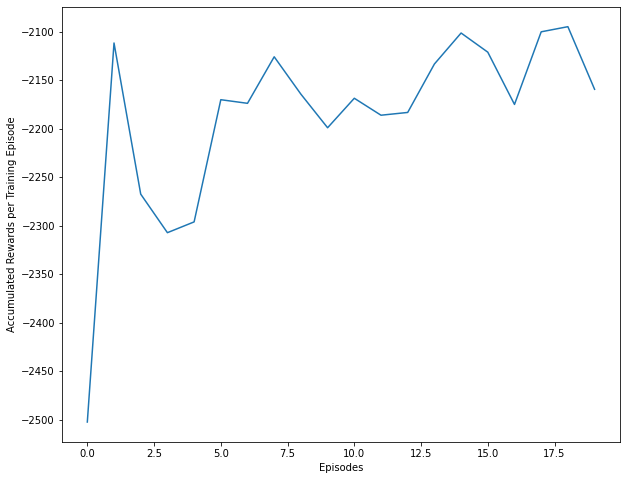

In [ ]:
acc_df = pd.DataFrame(accumulated_rewards, columns=['accumulated_rewards'])
acc_df.to_csv('mcts_accumulated_rewards.csv',index=False)

rew = [np.mean(accumulated_rewards[1000*i:1000*(i+1)]) for i in range(CONST_N_EPISODES)]
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(rew)
ax.set(xlabel='Episodes', ylabel='Accumulated Rewards per Training Episode')
plt.show() 

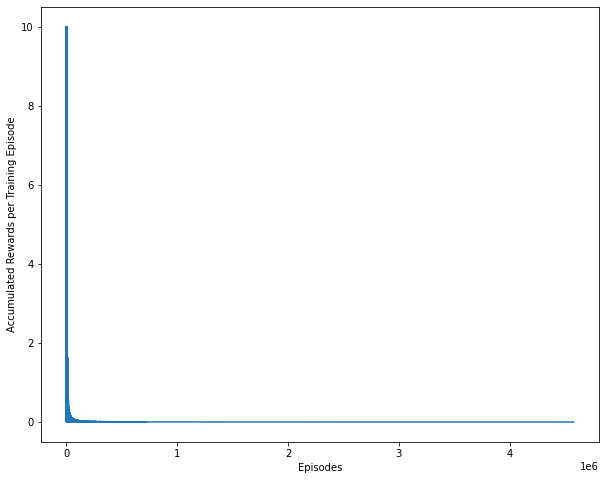

In [ ]:
# rew = [np.mean(accumulated_rewards[1000*i:1000*(i+1)]) for i in range(CONST_N_EPISODES)]
df = pd.DataFrame(Deltas, columns=['accumulated_rewards'])
df.to_csv('mcts_delta.csv',index=False)
# from google.colab import files
# files.download('mcts_delta.csv')


fig, ax = plt.subplots(figsize=(10,8))
plt.plot(Deltas)
ax.set(xlabel='Episodes', ylabel='Accumulated Rewards per Training Episode')
plt.show() 

In [ ]:
# V[(1,4)] = -1000
V[goal] = pend

def visualize_path(state_values, visited, policy):
    # def optimal_path_():
    path = np.empty(shape=(nrows, ncols))

    for i in range(nrows):
        for j in range(ncols):
            if (i,j) in visited:
                path[(i,j)] = 1
            elif (i,j) in blocked_cells:
                path[(i,j)] = -1
            else:
                path[(i,j)] = 0

    fig, axs = plt.subplots(figsize=(10,8))
    axs = sns.heatmap(path, cmap="YlGnBu", linewidths=.5, ax=axs)
    plt.show()


def visualize_values(V, policy):
    node_x = [0]*nrows
    node_y = [0]*ncols
    policy_2d = [[ ' ' for i in range(nrows) ] for j in range(nrows)]
    V_2d = [[ ' ' for i in range(ncols) ] for j in range(ncols)]
    for x in range(0,nrows,1):
        node_x[x] = x
        node_y[x] = x
        for y in range(0,ncols,1):
            if (x, y) == goal:
                V_2d[x][y] = pend
                policy_2d[x][y] = 'Goal'
            elif (x,y) not in policy.keys():
                policy_2d[x][y] = 'Wall'
                V_2d[x][y] = wall
            else:
                policy_2d[x][y] = policy[(x, y)]
                V_2d[x][y] = V[(x, y)]

    plot_direction_df = DataFrame(V_2d, index=node_x, columns=node_y)
    
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax1 = sns.heatmap(plot_direction_df, annot=policy_2d, fmt="", cmap = "YlGnBu")
    plt.show()
    
    fig, ax2 = plt.subplots(figsize=(15,10))
    ax2 = sns.heatmap(plot_direction_df, annot=True, fmt=".4f", cmap = "YlGnBu")
    plt.show()


def visualize(state_values, policy):

    visited = [start]
    for curr_cell_ in visited:
        i, j = curr_cell_ 
        temp = {}
        if ((i+1,j) in free_cells or (i+1,j) in terminal_states) and (i+1,j) not in visited: 
            temp[(i+1, j)] = state_values[(i+1,j)]

        if ((i-1,j) in free_cells or (i-1,j) in terminal_states) and (i-1,j) not in visited:
            temp[(i-1, j)] = state_values[(i-1,j)]

        if ((i,j+1) in free_cells or (i,j+1) in terminal_states) and (i,j+1) not in visited:
            temp[(i, j+1)] = state_values[(i,j+1)]

        if ((i,j-1) in free_cells or (i,j-1) in terminal_states) and (i,j-1) not in visited:
            temp[(i, j-1)] = state_values[(i,j-1)]

        temp_max = max(list(temp.values()))

        for x,y in temp.items():
            if y == temp_max:     next_cell_ = x

        visited.append(next_cell_)
        if next_cell_ == goal:     break    

    visualize_path(state_values, visited, policy)
    visualize_values(state_values, policy)

    return visited

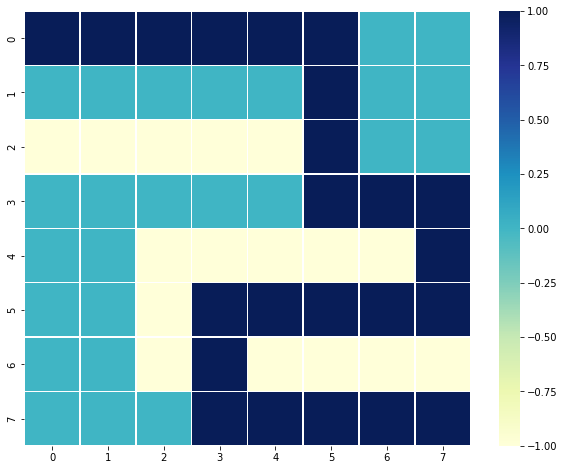

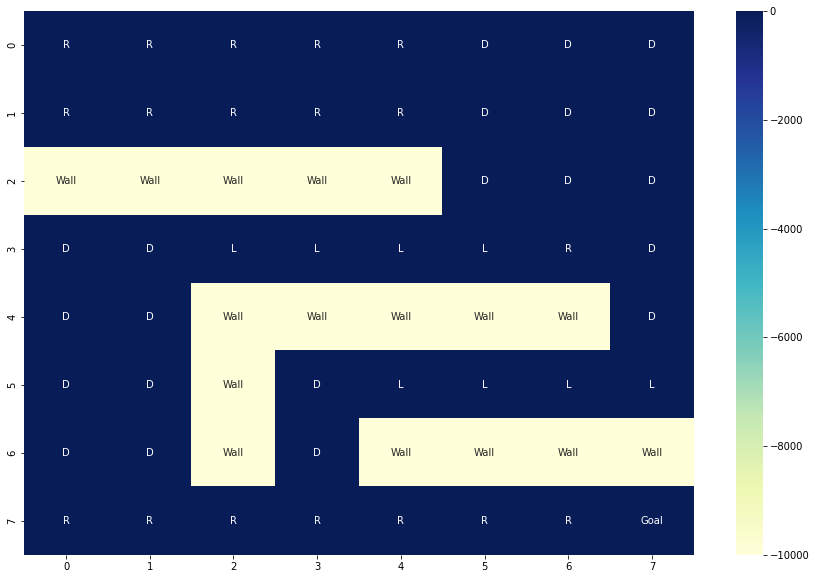

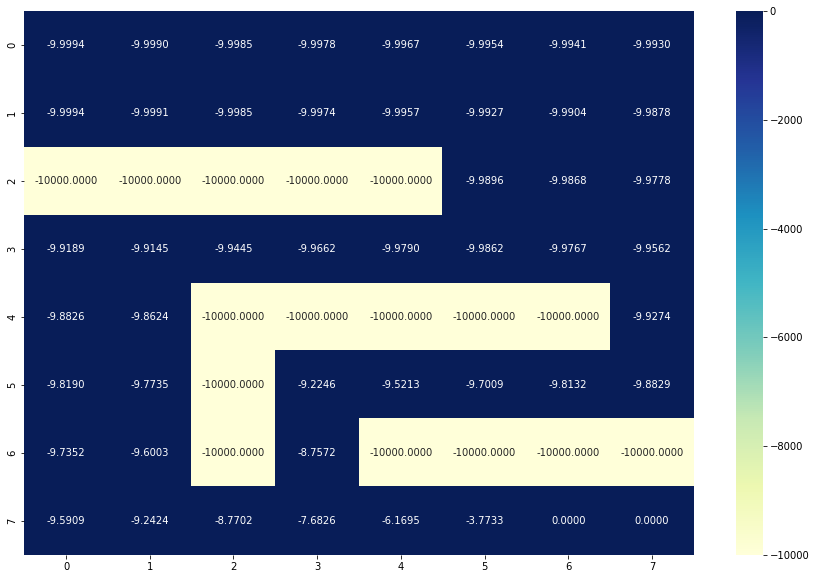

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 5),
 (2, 5),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 7),
 (5, 7),
 (5, 6),
 (5, 5),
 (5, 4),
 (5, 3),
 (6, 3),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [ ]:
visualize(V, Policy)

In [ ]:
pi_delta = pd.read_csv("pi_delta.csv")["accumulated_rewards"].tolist()
mcts_delta = pd.read_csv("mcts_delta.csv")["accumulated_rewards"].tolist()
vi_delta = pd.read_csv("vi_delta.csv")["accumulated_rewards"].tolist()

In [ ]:
from sklearn import preprocessing
pi_delta_norm = preprocessing.normalize([pi_delta])
vi_delta_norm = preprocessing.normalize([vi_delta])
mcts_delta_norm = preprocessing.normalize([mcts_delta])

In [ ]:
n=100
pi_delta_rew = [sum(pi_delta_norm[0][i:i+n])/n for i in range(0,len(pi_delta_norm[0]),n)]
vi_delta_rew = [sum(vi_delta_norm[0][i:i+n])/n for i in range(0,len(vi_delta_norm[0]),n)]
mcts_delta_rew = [sum(mcts_delta_norm[0][i:i+96*n])/96*n for i in range(0,len(mcts_delta_norm[0]),96*n)]

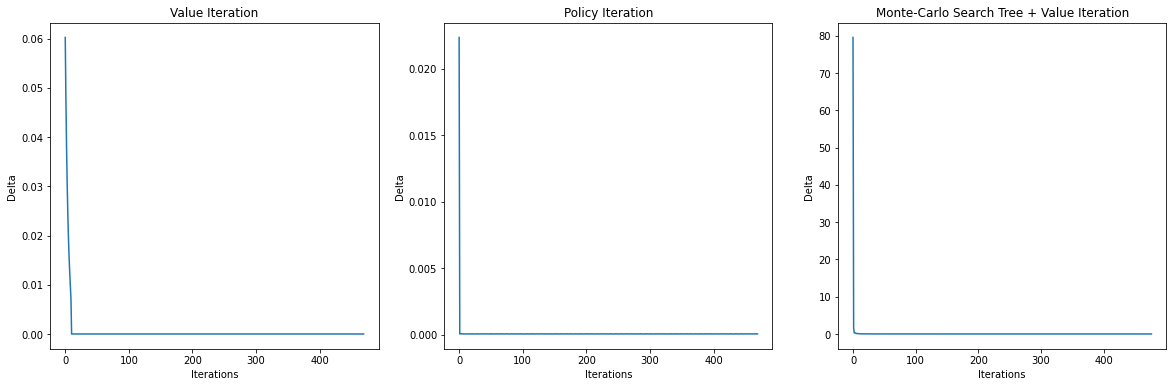

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, figsize=(20,6))
ax1.plot(vi_delta_rew)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Delta")
ax1.set_title("Value Iteration")

ax2.plot(pi_delta_rew)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Delta")
ax2.set_title("Policy Iteration")

ax3.plot(mcts_delta_rew)
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Delta")
ax3.set_title("Monte-Carlo Search Tree + Value Iteration")
plt.show()



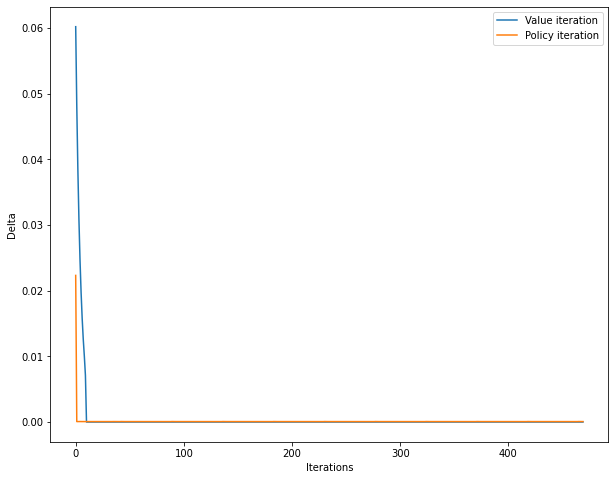

In [ ]:
figs, axs = plt.subplots(figsize=(10,8))
axs.plot(vi_delta_rew)
axs.plot(pi_delta_rew)
axs.set_xlabel("Iterations")
axs.set_ylabel("Delta")
# axs.plot(mcts_delta_rew)
plt.legend(['Value iteration', 'Policy iteration'])

In [ ]:
pi_acc = pd.read_csv("pi_accumulated_rewards.csv")["accumulated_rewards"].tolist()
mcts_acc = pd.read_csv("mcts_accumulated_rewards.csv")["accumulated_rewards"].tolist()
mcts_acc_rew = [sum(mcts_acc[i:i+20*n])/20*n for i in range(0,len(mcts_acc),20*n)]

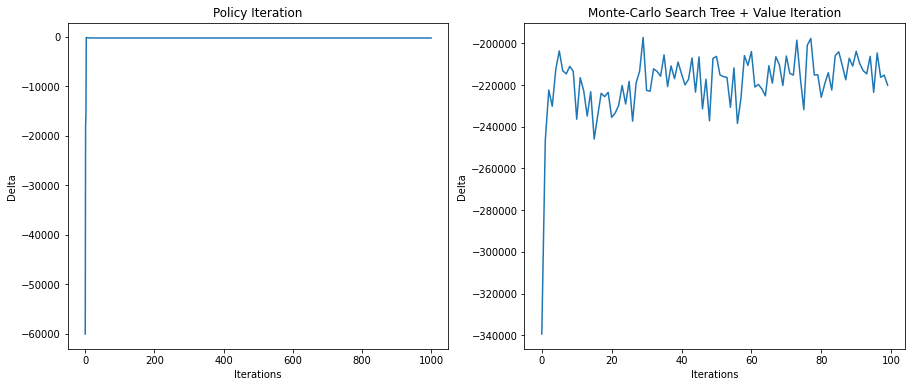

In [ ]:
fig, ((ax2, ax3)) = plt.subplots(ncols=2, figsize=(15,6))
ax2.plot(pi_acc)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Delta")
ax2.set_title("Policy Iteration")

ax3.plot(mcts_acc_rew)
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Delta")
ax3.set_title("Monte-Carlo Search Tree + Value Iteration")
plt.show()